# NEID Spectral Stitching and Flux-Conserving Rebinning

This Jupyter Notebook demonstrates the process of reading, normalizing, and stitching echelle spectral orders from NEID Data Standard FITS files for the star Tau Ceti. The workflow includes:

- Loading NEID spectral data from a FITS file.
- Normalizing the science spectrum by the blaze function.
- Calculating the spectral envelope to correct for the lamp spectral energy distribution (SED).
- Stitching and flux-conserving rebinning of spectral orders onto a common wavelength grid.
- Visualizing both the stitched spectrum and the order-by-order normalized spectra.

The notebook uses `astropy`, `specutils`, `scipy`, `numpy`, and `matplotlib` for data handling, spectral manipulation, and plotting.

**Key variables and steps:**
- `sci_flx`, `sci_wav`, `sci_blz`: Science flux, wavelength, and blaze arrays from the FITS file.
- `stitch_orders`: Main function to stitch and rebin the orders.
- `calculate_spectral_envelope`: Computes the envelope for blaze correction.
- `st_wave`, `st_flux`: Final stitched and rebinned spectrum.
- Visualization of both the stitched spectrum and individual orders.

This workflow is useful for preparing high-resolution echelle spectra for further scientific analysis, such as radial velocity measurements or stellar parameter determination.

In [2]:
import numpy as np
from astropy import units as u
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
from scipy.interpolate import interp1d


def calculate_spectral_envelope(wave, flux, wavepoints=None, boxsize = 100, percentile=99, fsr=None):
    """Calculate a envelope function across spectral orders.

    Parameters
    ----------
    wave : wavelength array (norders x npixels)

    flux : flux array (norders x npixels)


    Keywords
    --------
    wavepoints : array of wavelengths to use for calculating the envelope
                 flux.  If None, then the wavelengths are derived based on the
                 peak of the spectrum

    boxsize : int - size of box centered on each value in wavepoints for which
              to calculate fluxout

    percentile : int - threshold in percent to use for deriving the peak 
                flux.  Not used if wave is specified

    fsr : Free spectral range mask array, corresponding in size to the format 
          of nd flux and wavelength extensions.  If specified, restrict the 
          peak search to within these bounds

    Returns
    -------
    waveout, fluxout : arrays of length equal to the number of orders in nd. 


    2021-04-30, CFB
    """

    if wave.shape == flux.shape:
        norders, npixels = wave.shape
    else:
        print('wave and flux array not equal shape')
        return (None, None)
    
    #Parse the FSR mask
    pixstart = np.zeros(norders)
    pixend = np.ones(norders) * (npixels-1)
    if fsr is not None:
        if fsr.shape == wave.shape:
            for o in range(norders):
                if np.sum(np.logical_not(fsr[o,:])) == 0:
                    pixstart[o] = np.nan
                    pixend[o] = np.nan
                else:
                    pixstart[o] = np.min(np.argwhere(np.logical_not(fsr[o,:])))
                    pixend[o] = np.max(np.argwhere(np.logical_not(fsr[o,:])))
        else:
            print('fsr and wave not equal shape.  not using fsr')


    if wavepoints is not None:
        #Wavelengths are specified
        #Calculate fluxes at these points
        wavepoints = np.array(wavepoints) #Ensure this is a numpy array
        #Remove any nans and zeros
        wavepoints = wavepoints[~np.isnan(wavepoints)]
        wavepoints = wavepoints[wavepoints!=0]
        #For each wavepoint, identify the order index where the point is closest to the order midpoint
        #Note that this ignores the FSR mask...
        worder = [np.nanargmin(np.abs(wave[:,int(npixels/2)] - w)) for w in wavepoints]
        #Calculate the index in each order that corresponds to the order,wavepoint pair
        windex = [np.nanargmin(np.abs(wave[w[0],:]-w[1])) for w in zip(worder,wavepoints)]
        #Calculate the flux percentile threshold at these points
        waveout = wavepoints
        fluxout = np.empty(len(wavepoints))
        hbox = int(boxsize/2)
        for i in range(len(windex)):
            f = flux[worder[i],max([windex[i]-hbox,0]):min([windex[i]+hbox,npixels-1])]
            fluxout[i] = np.percentile(f, percentile)
    else:
        #Calculate the envelope 
        fluxout = np.empty(norders) * np.nan
        waveout = np.empty(norders) * np.nan
        for o in range(norders):
            if ~np.isnan(pixstart[o]): #Only need to check start; end nan is tied to start
                f = flux[o,int(pixstart[o]):int(pixend[o])]
                w = wave[o,int(pixstart[o]):int(pixend[o])]
                fluxout[o] = np.percentile(f[~np.isnan(f)],percentile)
                waveout[o] = np.nanmean(w[np.where(f > fluxout[o])])


    return (waveout, fluxout)


def resample_flux_conserving(sci_wav, sci_dflx, spec_mask, nbins):
    """flux-conserving rebinning and stitching of spectral orders
    
    Parameters
    ----------
    sci_wav : 2D numpy array
        Wavelengths of the science spectrum, shape (norders, npixels).
    sci_dflx : 2D numpy array
        Fluxes of the science spectrum, shape (norders, npixels).
    spec_mask : 2D boolean numpy array
        Mask for the science spectrum, shape (norders, npixels).
    nbins : int
        Number of bins for the stitched spectrum.
    
    Returns
    -------
    st_wave : 1D numpy array
        Wavelengths of the stitched spectrum.
    st_flux : 1D numpy array
        Fluxes of the stitched spectrum.
    
    2025-06-21, LPA
    """
    norders = sci_wav.shape[0]
    orders = []
    for iorder in range(norders):
        wave = sci_wav[iorder,:] * u.AA
        flux = sci_dflx[iorder,:] * u.Unit('adu')       # or the correct unit
        mask = spec_mask[iorder,:]  # boolean mask for NaNs or bad pixels
        orders.append(Spectrum1D(spectral_axis=wave,flux=flux,mask=mask))

  
    # Define a common output grid

    min_wave = min(spec.spectral_axis.min() for spec in orders)
    max_wave = max(spec.spectral_axis.max() for spec in orders)
    new_wave = np.linspace(min_wave.value,max_wave.value,nbins) * min_wave.unit

    # Rebin each order (flux-conserving)

    resampler = FluxConservingResampler()

    rebinned_orders = []
    for spec in orders:
        rebinned = resampler(spec, new_wave)
        rebinned_orders.append(rebinned)


    # Combine overlapping orders

    # Stack the flux arrays and take a nan-mean
    flux_stack = np.vstack([spec.flux.value for spec in rebinned_orders])
    combined_flux = np.nanmean(flux_stack, axis=0) * rebinned_orders[0].flux.unit

    st_wave = new_wave.value
    st_flux = combined_flux.value 

    return st_wave, st_flux


def stitch_orders(sci_wav, sci_flx, sci_blz,inst_stitch_config_sel='NEID'):#, inst_stitch_config=stitch_config['NEID']):
    """Stitch the spectral orders of a science spectrum.

    Parameters
    ----------
    sci_wav : 2D numpy array
        Wavelengths of the science spectrum, shape (norders, npixels).
    sci_flx : 2D numpy array
        Fluxes of the science spectrum, shape (norders, npixels).
    sci_blz : 2D numpy array
        Blaze function of the science spectrum, shape (norders, npixels).
    inst_stitch_config : dict, optional
        Instrument-specific stitching configuration parameters.
        Default is for NEID.

    Returns
    -------
    st_wave : 1D numpy array
        Wavelengths of the stitched spectrum.
    st_flux : 1D numpy array
        Fluxes of the stitched spectrum.

    2025-06-21, LPA
    """
    # instrument configuration parameters
    stitch_config = {'NEID': {
    'iordermin': 4,  # First order to include in stitching
    'iorderflatbreak': 78,  # Order where the flat breaks
    'iordermax': 116,  # Last order to include in stitching
    'nbins': 50000  # Number of bins for the stitched spectrum
    }}
    inst_stitch_config = stitch_config[inst_stitch_config_sel]
    
    iordermin = inst_stitch_config['iordermin']
    iorderflatbreak = inst_stitch_config['iorderflatbreak']
    iordermax = inst_stitch_config['iordermax']
    nbins = inst_stitch_config['nbins']

    # Prepare the science data
    sci_dflx = sci_flx/(sci_blz/np.nanmax(sci_blz,axis=1,keepdims=True))  # Normalize by blaze function

    sciflx_mask = np.isnan(sci_flx)
    sciwav_mask = (sci_wav==0.) | np.isnan(sci_wav)
    sciblz_mask = np.isnan(sci_blz)
    spec_mask   = np.logical_or(sciflx_mask,sciwav_mask,sciblz_mask)

    # Mask data where the spectrum is bad or missing
    sci_flxm  = np.where(spec_mask,float('nan'),sci_flx)
    sci_wavm  = np.where(spec_mask,float('nan'),sci_wav)
    sci_blzm  = np.where(spec_mask,float('nan'),sci_blz)
    sci_dflxm = np.where(spec_mask,float('nan'),sci_dflx)

    # Calculate the spectral envelope for the blaze extension
    sci_bzewavb, sci_bzbeenvb = calculate_spectral_envelope(sci_wavm[iordermin:iorderflatbreak,:], sci_blzm[iordermin:iorderflatbreak,:])#, fsr=fsrmask[:78,:])
    sci_bzewavr, sci_bzbeenvr = calculate_spectral_envelope(sci_wavm[iorderflatbreak:iordermax,:], sci_blzm[iorderflatbreak:iordermax,:])#, fsr=fsrmask[78:,:])
    sci_bzewav = np.concatenate((sci_bzewavb, sci_bzewavr), axis=0)
    sci_bzbeenv = np.concatenate((sci_bzbeenvb, sci_bzbeenvr), axis=0)

    # Interpolate the spectral envelope to the wavelength grid of the science data
    sci_bzenvb = interp1d(sci_bzewavb, sci_bzbeenvb, bounds_error=False, fill_value='extrapolate')(sci_wavm[iordermin:iorderflatbreak,:])
    sci_bzenvr = interp1d(sci_bzewavr, sci_bzbeenvr, bounds_error=False, fill_value='extrapolate')(sci_wavm[iorderflatbreak:iordermax,:])
    sci_bzenv = np.concatenate((sci_bzenvb, sci_bzenvr), axis=0)
    sci_bzenvn = sci_bzenv/np.nanmax(sci_bzenv,axis=1,keepdims=True)

    # Normalize the science data by the spectral envelope, correcting the lamp SED
    sci_dblzed_flx = sci_dflxm[iordermin:iordermax,:] * sci_bzenvn

    # Resample the flux-conserving and stitch the orders
    st_wave, st_flux = resample_flux_conserving(sci_wav[iordermin:iordermax,:], sci_dblzed_flx, spec_mask[iordermin:iordermax,:], nbins)

    return st_wave, st_flux

In [5]:
from astropy.io import fits
spec_fp = 'neidL2_20241101T053244_Standardized.fits'
# Read the spectrum data from the Data Standard FITS file
with fits.open(spec_fp,mode='readonly') as hdu:
    hdr  = hdu[0].header
    sci_flx = hdu['TRACE1_FLUX'].data # 4-116 order in NEID out of 122
    sci_wav = hdu['TRACE1_WAVE'].data
    sci_blz = hdu['TRACE1_BLAZE'].data

In [6]:
st_wave, st_flux = stitch_orders(sci_wav, sci_flx, sci_blz,inst_stitch_config_sel='NEID')

/var/folders/hf/f8xgjs196vv17jxk4kktx5l80000gn/T/ipykernel_10632/2369017530.py:197: RuntimeWarning: invalid value encountered in divide
  sci_dflx = sci_flx/(sci_blz/np.nanmax(sci_blz,axis=1,keepdims=True))  # Normalize by blaze function
/var/folders/hf/f8xgjs196vv17jxk4kktx5l80000gn/T/ipykernel_10632/2369017530.py:150: RuntimeWarning: Mean of empty slice
  combined_flux = np.nanmean(flux_stack, axis=0) * rebinned_orders[0].flux.unit


In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib
matplotlib.pyplot.rcdefaults()
matplotlib.rcParams['font.family'] = 'Arial Narrow'
matplotlib.rcParams['font.size']   = 15
matplotlib.rcParams['axes.linewidth'] = 1.25

matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True

matplotlib.rcParams['xtick.minor.visible'] = True   # visibility of minor ticks on x-axis
matplotlib.rcParams['ytick.minor.visible'] = True   # visibility of minor ticks on y-axis

matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

matplotlib.rcParams['xtick.major.size'] = 9.0       # major tick size in points
matplotlib.rcParams['xtick.minor.size'] = 4.0       # minor tick size in points
matplotlib.rcParams['ytick.major.size'] = 9.0       # major tick size in points
matplotlib.rcParams['ytick.minor.size'] = 4.0       # minor tick size in points

matplotlib.rcParams['xtick.major.width'] = 1.25     # major tick width in points
matplotlib.rcParams['xtick.minor.width'] = 1.0     # minor tick width in points
matplotlib.rcParams['ytick.major.width'] = 1.25     # major tick width in points
matplotlib.rcParams['ytick.minor.width'] = 1.0     # minor tick width in points

matplotlib.rcParams['date.autoformatter.month'] = '%Y %b'
matplotlib.rcParams['date.autoformatter.day'] = '%Y %b %d'
matplotlib.rcParams['date.autoformatter.hour'] = '%b %d\n%Hh'
matplotlib.rcParams['date.autoformatter.minute'] = '%b %d\n%H:%M'

matplotlib.rcParams['grid.linewidth'] = 1.25

import ipympl

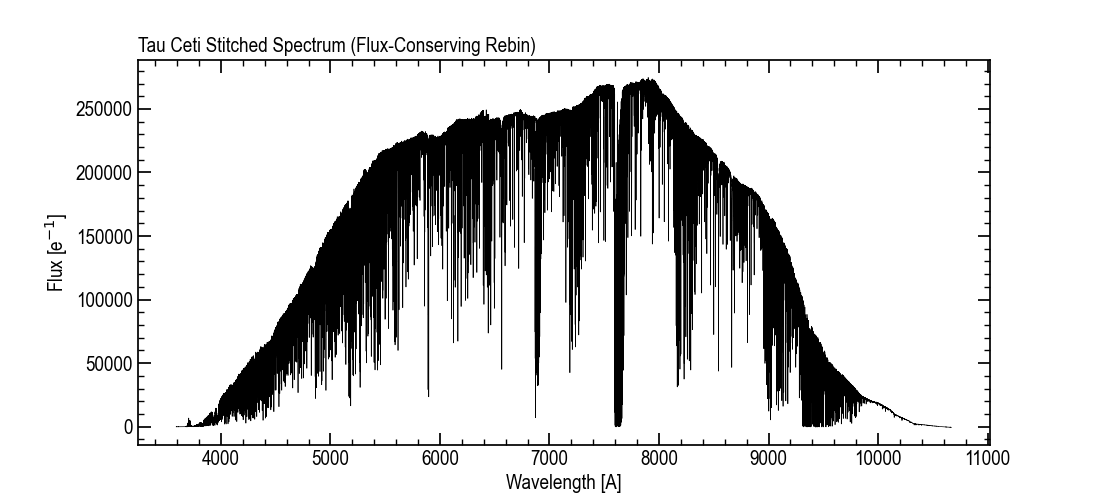

In [8]:
f, ax = plt.subplots(1,1,figsize=(11,5))
ax.step(st_wave,st_flux, where='mid', c='k', lw=0.5)


ax.set_xlabel('Wavelength [A]')
ax.set_ylabel('Flux [e$^{-1}$]')
ax.set_title('Tau Ceti Stitched Spectrum (Flux-Conserving Rebin)',loc='left',color='black',fontsize=15)

plt.show()

In [9]:
# instrument configuration parameters
stitch_config = {'NEID': {
'iordermin': 4,  # First order to include in stitching
'iorderflatbreak': 78,  # Order where the flat breaks
'iordermax': 116,  # Last order to include in stitching
'nbins': 50000  # Number of bins for the stitched spectrum
}}
inst_stitch_config = stitch_config['NEID']

iordermin = inst_stitch_config['iordermin']
iorderflatbreak = inst_stitch_config['iorderflatbreak']
iordermax = inst_stitch_config['iordermax']
nbins = inst_stitch_config['nbins']

# Prepare the science data
sci_dflx = sci_flx/(sci_blz/np.nanmax(sci_blz,axis=1,keepdims=True))  # Normalize by blaze function

sciflx_mask = np.isnan(sci_flx)
sciwav_mask = (sci_wav==0.) | np.isnan(sci_wav)
sciblz_mask = np.isnan(sci_blz)
spec_mask   = np.logical_or(sciflx_mask,sciwav_mask,sciblz_mask)

# Mask data where the spectrum is bad or missing
sci_flxm  = np.where(spec_mask,float('nan'),sci_flx)
sci_wavm  = np.where(spec_mask,float('nan'),sci_wav)
sci_blzm  = np.where(spec_mask,float('nan'),sci_blz)
sci_dflxm = np.where(spec_mask,float('nan'),sci_dflx)

# Calculate the spectral envelope for the blaze extension
sci_bzewavb, sci_bzbeenvb = calculate_spectral_envelope(sci_wavm[iordermin:iorderflatbreak,:], sci_blzm[iordermin:iorderflatbreak,:])#, fsr=fsrmask[:78,:])
sci_bzewavr, sci_bzbeenvr = calculate_spectral_envelope(sci_wavm[iorderflatbreak:iordermax,:], sci_blzm[iorderflatbreak:iordermax,:])#, fsr=fsrmask[78:,:])
sci_bzewav = np.concatenate((sci_bzewavb, sci_bzewavr), axis=0)
sci_bzbeenv = np.concatenate((sci_bzbeenvb, sci_bzbeenvr), axis=0)

# Interpolate the spectral envelope to the wavelength grid of the science data
sci_bzenvb = interp1d(sci_bzewavb, sci_bzbeenvb, bounds_error=False, fill_value='extrapolate')(sci_wavm[iordermin:iorderflatbreak,:])
sci_bzenvr = interp1d(sci_bzewavr, sci_bzbeenvr, bounds_error=False, fill_value='extrapolate')(sci_wavm[iorderflatbreak:iordermax,:])
sci_bzenv = np.concatenate((sci_bzenvb, sci_bzenvr), axis=0)
sci_bzenvn = sci_bzenv/np.nanmax(sci_bzenv,axis=1,keepdims=True)

# Normalize the science data by the spectral envelope, correcting the lamp SED
sci_dblzed_flx = sci_dflxm[iordermin:iordermax,:] * sci_bzenvn

/var/folders/hf/f8xgjs196vv17jxk4kktx5l80000gn/T/ipykernel_10632/608017079.py:16: RuntimeWarning: invalid value encountered in divide
  sci_dflx = sci_flx/(sci_blz/np.nanmax(sci_blz,axis=1,keepdims=True))  # Normalize by blaze function


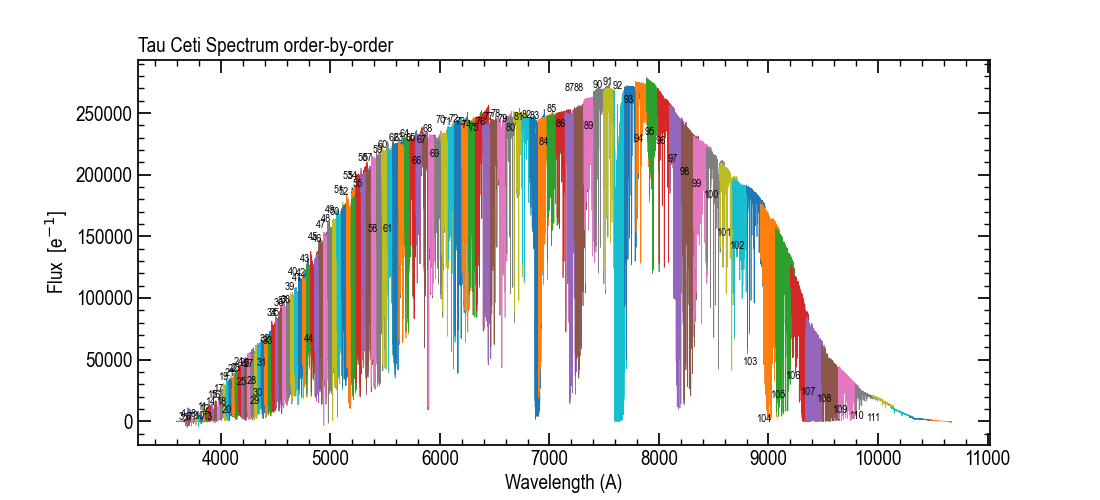

In [16]:
f, ax = plt.subplots(1,1,figsize=(11,5))


yflux = sci_dblzed_flx.copy()
for cord in range(iordermin,iordermax):
    #yflux[iord,:] = sci_dflxm[iord,:]*sci_bzenvn[iord,:]
    iord = cord - iordermin
    ax.step(sci_wavm[cord,:],yflux[iord,:], where='mid', lw=0.5)
    ax.annotate(f'{iord}', xy=(sci_wavm[iord,4608], yflux[iord,4608]), xycoords='data', fontsize=8, color='black')


ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux  [e$^{-1}$]')
ax.set_title('Tau Ceti Spectrum order-by-order',loc='left',color='black',fontsize=15)

plt.show()